<a href="https://colab.research.google.com/github/StillWork/c9/blob/master/gg_66_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_%E1%84%8F%E1%85%B3%E1%86%AF%E1%84%85%E1%85%A5%E1%84%89%E1%85%B3%E1%84%90%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC_410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰의 가속도 센서 데이터로 분류하는 예

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils

## 여섯개의 레이블을 사용한다.
- Downstairs, Jogging, Sitting, Standing, Upstairs, Walking


In [5]:
# 소수점 세 자리만 표시
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=3)

LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

위의 파일 다운로드 및 압축풀기가 성공적으로 안되면 아래 사이트에서 직접 데이터를 다운받아 로컬 컴퓨터의 alzip 이나 다른 압축 프로그램을 이용해 압축을 푼 다음 사용해야 한다. Colab을 사용할 때에는 서브 폴더 data를 만든 다음 그 곳에 압축이 풀린 해당 파일을 업로드하기 바란다. (Colab 의 홈 디렉토리에 바로 저장하고 그곳에서 수행해도 된다.) https://www.cis.fordham.edu/wisdm/dataset.php

In [6]:
from google.colab import files
files.upload()

Saving WISDM_ar_latest.tar.gz to WISDM_ar_latest.tar.gz


In [20]:
#import os, os.path, shutil
#if not os.path.exists("./data"):
#    os.makedirs("./data")
#!curl http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz \
# -o ./data/WISDM_ar_latest.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   289  100   289    0     0   6020      0 --:--:-- --:--:-- --:--:--  6020


In [7]:
#fname = './data/WISDM_ar_latest.tar.gz'
fname = './WISDM_ar_latest.tar.gz'
import tarfile
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('./data')
    tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open(fname, "r:")
    tar.extractall('./data')
    tar.close()

In [8]:
!head -5 ./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [9]:
def read_data(file_path):
    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # 마지막 컬럼에서 ";"를 삭제
  
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # 모두 소수로 변환 (현재 문자열로 바뀌어 있음)
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # 결측치 처리
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
 

df = read_data('./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [10]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.695,12.681,0.504
1,33,Jogging,49106062271000,5.012,11.264,0.953
2,33,Jogging,49106112167000,4.903,10.883,-0.082
3,33,Jogging,49106222305000,-0.613,18.496,3.024
4,33,Jogging,49106332290000,-1.185,12.108,7.205


In [11]:
df.shape

(1098203, 6)

In [12]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

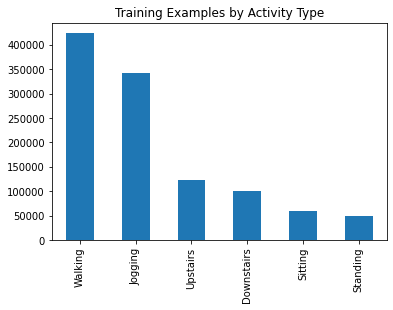

In [13]:
df['activity'].value_counts().plot(kind='bar',
                              title='Training Examples by Activity Type')
plt.show()

In [14]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

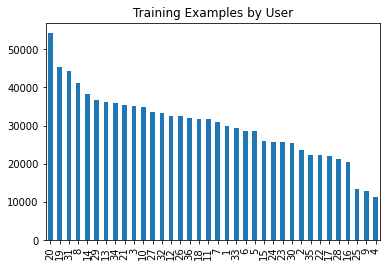

In [17]:
df['user-id'].value_counts().plot(kind='bar',title='Training Examples by User')
plt.show()

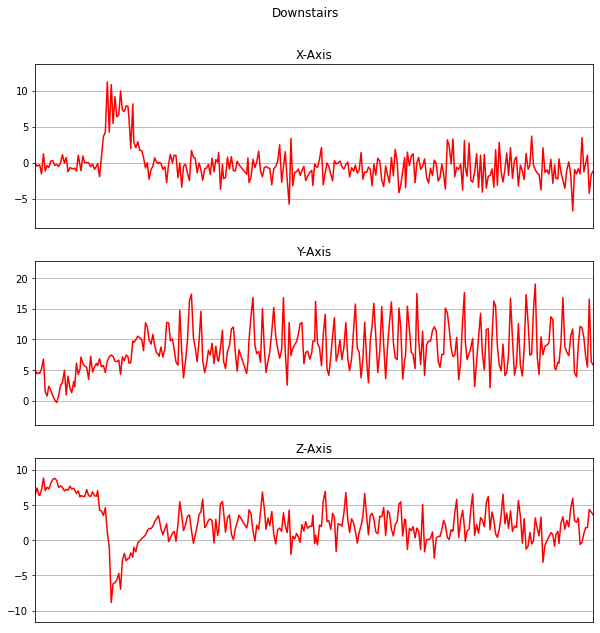

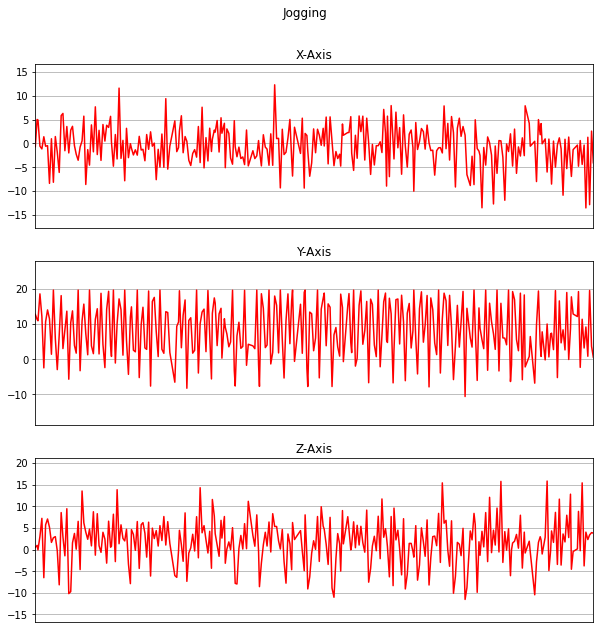

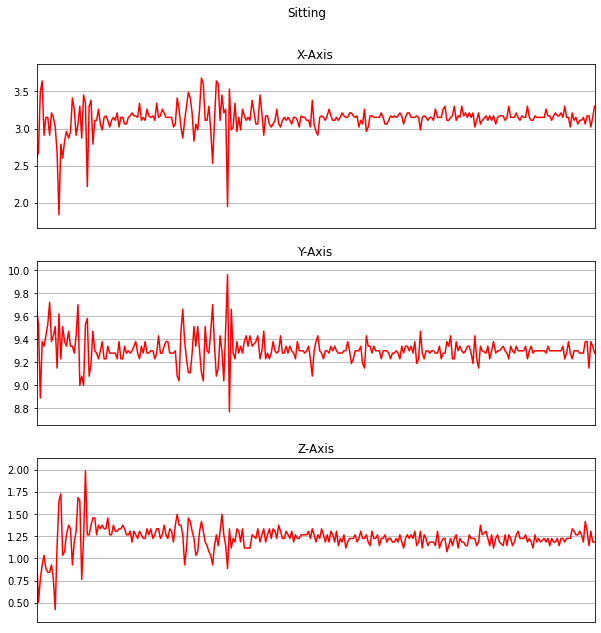

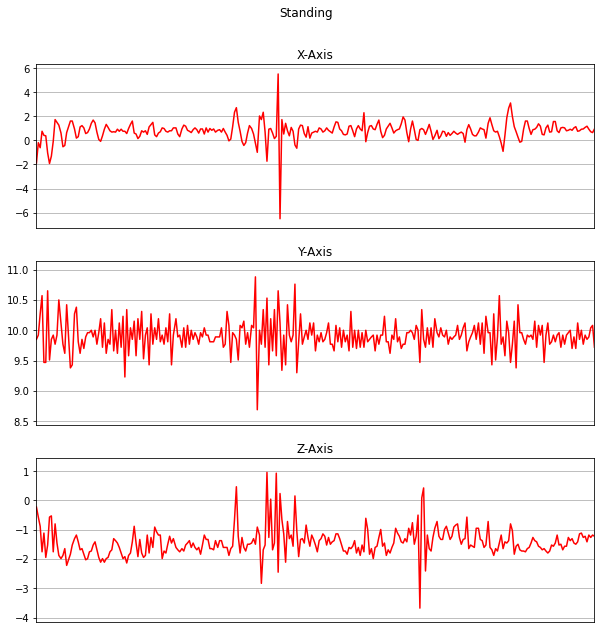

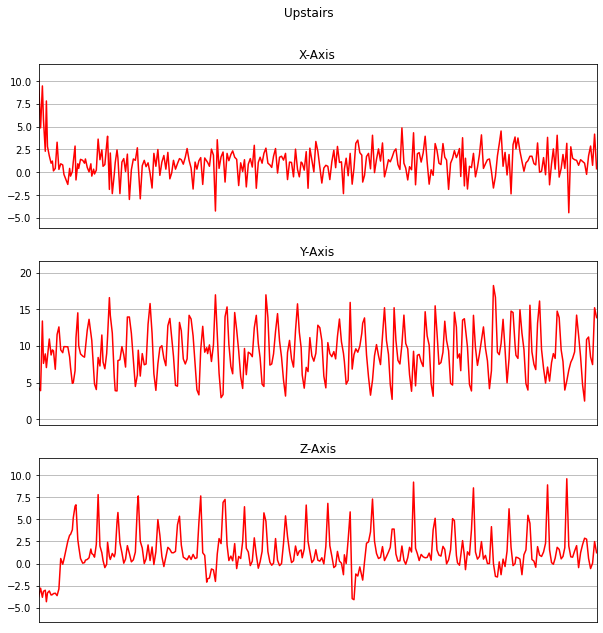

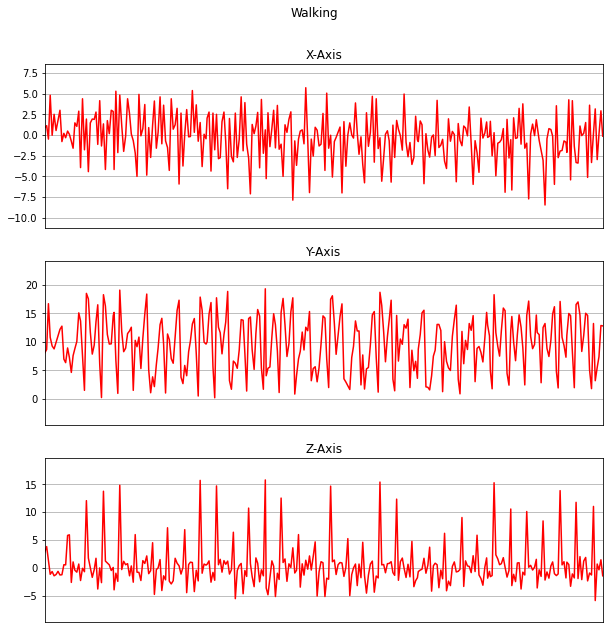

In [18]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:300]
    plot_activity(activity, subset)

In [19]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [20]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.695,12.681,0.504,1
1,33,Jogging,49106062271000,5.012,11.264,0.953,1
2,33,Jogging,49106112167000,4.903,10.883,-0.082,1
3,33,Jogging,49106222305000,-0.613,18.496,3.024,1
4,33,Jogging,49106332290000,-1.185,12.108,7.205,1


In [21]:
df['activity'].value_counts()

Walking       423905
Jogging       330330
Upstairs      122598
Downstairs    100194
Sitting        59939
Standing       48394
Name: activity, dtype: int64

In [22]:
test = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4]
stats.mode(test)

ModeResult(mode=array([3]), count=array([15]))

In [23]:
z = stats.mode(df['act'][0:100])
z[0][0], z[1][0]

(1, 100)

In [24]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis',
       'act'],
      dtype='object')

In [25]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [26]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198,0.792,0.018,1
1,33,Jogging,49106062271000,0.630,0.582,0.112,1
2,33,Jogging,49106112167000,0.614,0.525,-0.104,1
3,33,Jogging,49106222305000,-0.186,1.655,0.545,1
4,33,Jogging,49106332290000,-0.269,0.707,1.420,1


In [27]:
# N개 샘플씩 끊어서 유효한 (통일된) 동작 레이블을 찾는다 
N = 100
X_all = []
y = []
for i in range(0, len(df)-N+1, N):
    z = stats.mode(df['act'][i: i+N])
    action, count = z[0][0], z[1][0]
    if count == N:
        xs = df['x-axis'].values[i: i + N]
        ys = df['y-axis'].values[i: i + N]
        zs = df['z-axis'].values[i: i + N]
        X_all.append([xs, ys, zs])
        y.append(action)

    # Bring the segments into a better shape

X_all = np.asarray(X_all, dtype= np.float32)
y = np.asarray(y)

In [28]:
X_all.shape

(10469, 3, 100)

In [29]:
X_3 = np.transpose(X_all, (0,2,1))

In [30]:
X_3.shape

(10469, 100, 3)

In [31]:
# z-axis 성분만 추출
X = X_3[:,:,2]
X[0]

array([ 0.018,  0.112, -0.104,  0.545,  1.42 , -1.448,  1.106,  1.388,
        0.987,  0.258,  0.483,  0.537, -0.15 , -1.793,  1.699,  0.523,
       -0.392,  1.884, -2.217, -2.121,  0.235,  0.691, -0.07 ,  1.275,
       -1.055,  2.741,  1.203,  0.753,  0.409,  0.899,  0.09 ,  1.739,
       -0.36 ,  1.645,  0.098, -0.224,  0.748,  0.417, -0.745,  1.283,
        0.024,  0.073,  1.619, -0.671,  2.804,  0.192,  1.106,  0.448,
        0.329,  0.89 , -0.785, -1.736,  0.876,  0.642, -0.127,  1.266,
       -1.001,  1.115,  1.212,  0.705, -0.454,  1.235, -1.369,  0.947,
        0.443,  0.827,  0.081,  1.067,  0.346,  1.508,  0.129,  1.26 ,
        0.209, -1.346, -1.431, -0.144,  0.842,  0.152, -0.657,  1.685,
       -1.625, -0.255, -0.007,  0.651, -0.158,  1.5  , -0.489,  2.901,
        0.722,  1.067,  0.377, -0.255,  0.793, -0.993,  2.331,  1.531,
        0.682,  0.121, -0.415,  1.323], dtype=float32)

In [32]:
X.shape, y.shape

((10469, 100), (10469,))

In [34]:
y_hot = np_utils.to_categorical(y)
y_hot.shape

(10469, 6)

In [35]:
y_hot[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [36]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size = 0.2)
rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.6217765042979942

In [38]:
X_train.shape, y_train.shape

((8375, 100), (8375, 6))

In [39]:
model_m = Sequential()
model_m.add(Dense(100, activation='relu', input_shape=(100,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 20,806
Trainable params: 20,806
Non-trainable params: 0
_________________________________________________________________
None


## 동작 환경 설정
- 조기 종료 (2회 동안 개선되지 않으면 종료)
- 배키 크기 400
- 이포크 50
- 훈련데이터: 검증 데이터 = 8:2


In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 10
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

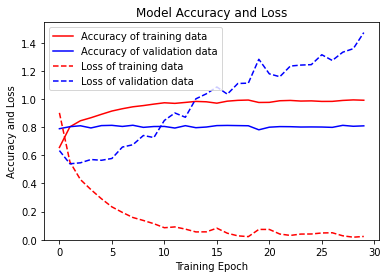

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [44]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

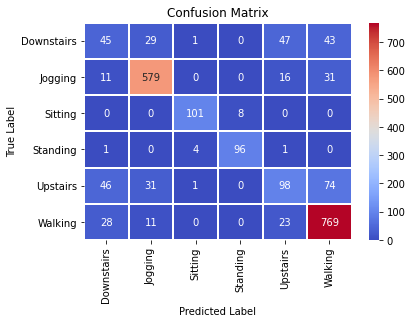

              precision    recall  f1-score   support

           0       0.34      0.27      0.30       165
           1       0.89      0.91      0.90       637
           2       0.94      0.93      0.94       109
           3       0.92      0.94      0.93       102
           4       0.53      0.39      0.45       250
           5       0.84      0.93      0.88       831

    accuracy                           0.81      2094
   macro avg       0.74      0.73      0.73      2094
weighted avg       0.79      0.81      0.79      2094



In [45]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

## CNN을 사용하여 성능을 개선

In [46]:
model_m = Sequential()
model_m.add(Reshape((N, 1), input_shape=(N,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(N,1)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 100, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 91, 100)           1100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 82, 100)           100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 160)           160160    
_________________________________________________________________
global_average_pooling1d (Gl (None, 160)               0         
_________________________________________________________________
dropout (Dropout)            (None, 160)              

In [47]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
335/335 [==============================] - 4s 4ms/step - loss: 1.0088 - accuracy: 0.5783 - val_loss: 0.4633 - val_accuracy: 0.8245
Epoch 2/30
335/335 [==============================] - 1s 3ms/step - loss: 0.4886 - accuracy: 0.8185 - val_loss: 0.3050 - val_accuracy: 0.8854
Epoch 3/30
335/335 [==============================] - 1s 3ms/step - loss: 0.3661 - accuracy: 0.8627 - val_loss: 0.3013 - val_accuracy: 0.8830
Epoch 4/30
335/335 [==============================] - 1s 3ms/step - loss: 0.2921 - accuracy: 0.8897 - val_loss: 0.2645 - val_accuracy: 0.9033
Epoch 5/30
335/335 [==============================] - 1s 3ms/step - loss: 0.2866 - accuracy: 0.8911 - val_loss: 0.2207 - val_accuracy: 0.9182
Epoch 6/30
335/335 [==============================] - 1s 3ms/step - loss: 0.2231 - accuracy: 0.9164 - val_loss: 0.2103 - val_accuracy: 0.9248
Epoch 7/30
335/335 [==============================] - 1s 3ms/step - loss: 0.2036 - accuracy: 0.9243 - val_loss: 0.1851 - val_accuracy: 0.9313
Epoch 

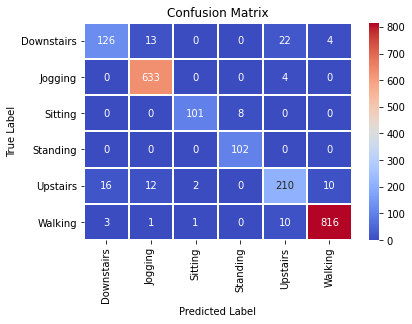

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       165
           1       0.96      0.99      0.98       637
           2       0.97      0.93      0.95       109
           3       0.93      1.00      0.96       102
           4       0.85      0.84      0.85       250
           5       0.98      0.98      0.98       831

    accuracy                           0.95      2094
   macro avg       0.93      0.92      0.92      2094
weighted avg       0.95      0.95      0.95      2094



In [48]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# RNN으로 학습

In [50]:
from keras.layers import GRU
model = Sequential()
model.add(Reshape((N,1), input_shape=(N,)))
model.add(GRU(256, return_sequences=True, 
                 input_shape=(N,1)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3) ]
model.compile(loss='categorical_crossentropy',
      optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 256)          198912    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 595,206
Trainable params: 595,206
Non-trainable params: 0
________________________________________________

Epoch 1/30
335/335 [==============================] - 7s 16ms/step - loss: 1.1805 - accuracy: 0.5374 - val_loss: 0.5383 - val_accuracy: 0.7988
Epoch 2/30
335/335 [==============================] - 5s 14ms/step - loss: 0.5498 - accuracy: 0.7993 - val_loss: 0.4490 - val_accuracy: 0.8245
Epoch 3/30
335/335 [==============================] - 5s 15ms/step - loss: 0.4255 - accuracy: 0.8439 - val_loss: 0.3673 - val_accuracy: 0.8585
Epoch 4/30
335/335 [==============================] - 5s 14ms/step - loss: 0.4109 - accuracy: 0.8500 - val_loss: 0.3277 - val_accuracy: 0.8734
Epoch 5/30
335/335 [==============================] - 5s 14ms/step - loss: 0.3116 - accuracy: 0.8860 - val_loss: 0.2889 - val_accuracy: 0.8890
Epoch 6/30
335/335 [==============================] - 5s 14ms/step - loss: 0.3249 - accuracy: 0.8862 - val_loss: 0.2660 - val_accuracy: 0.9021
Epoch 7/30
335/335 [==============================] - 5s 14ms/step - loss: 0.2558 - accuracy: 0.9126 - val_loss: 0.2413 - val_accuracy: 0.9045

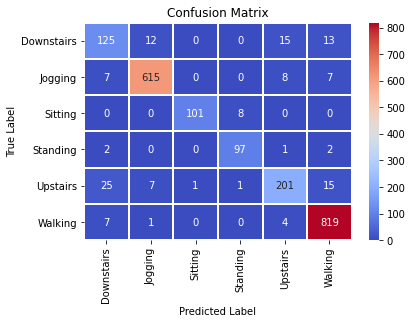

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       165
           1       0.97      0.97      0.97       637
           2       0.99      0.93      0.96       109
           3       0.92      0.95      0.93       102
           4       0.88      0.80      0.84       250
           5       0.96      0.99      0.97       831

    accuracy                           0.94      2094
   macro avg       0.91      0.90      0.90      2094
weighted avg       0.93      0.94      0.93      2094



In [51]:
history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# x,y,z 모두 사용할 때(Conv1D)

In [52]:
X_3.shape

(10469, 100, 3)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y_hot, test_size = 0.2)

model_m = Sequential()
model_m.add(Conv1D(64, 10, activation='relu',input_shape=(N,3)))
model_m.add(Conv1D(64, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(128, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(6, activation='softmax'))
# print(model_m.summary())

In [54]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
335/335 [==============================] - 2s 3ms/step - loss: 0.8453 - accuracy: 0.6727 - val_loss: 0.4091 - val_accuracy: 0.8430
Epoch 2/30
335/335 [==============================] - 1s 3ms/step - loss: 0.3115 - accuracy: 0.8863 - val_loss: 0.1963 - val_accuracy: 0.9361
Epoch 3/30
335/335 [==============================] - 1s 3ms/step - loss: 0.2008 - accuracy: 0.9358 - val_loss: 0.1246 - val_accuracy: 0.9594
Epoch 4/30
335/335 [==============================] - 1s 3ms/step - loss: 0.1336 - accuracy: 0.9544 - val_loss: 0.1532 - val_accuracy: 0.9463
Epoch 5/30
335/335 [==============================] - 1s 3ms/step - loss: 0.1037 - accuracy: 0.9668 - val_loss: 0.1025 - val_accuracy: 0.9707
Epoch 6/30
335/335 [==============================] - 1s 3ms/step - loss: 0.0814 - accuracy: 0.9749 - val_loss: 0.0896 - val_accuracy: 0.9761
Epoch 7/30
335/335 [==============================] - 1s 3ms/step - loss: 0.0721 - accuracy: 0.9779 - val_loss: 0.0779 - val_accuracy: 0.9779
Epoch 

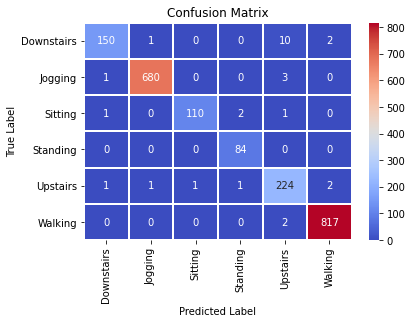

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       163
           1       1.00      0.99      1.00       684
           2       0.99      0.96      0.98       114
           3       0.97      1.00      0.98        84
           4       0.93      0.97      0.95       230
           5       1.00      1.00      1.00       819

    accuracy                           0.99      2094
   macro avg       0.98      0.98      0.98      2094
weighted avg       0.99      0.99      0.99      2094



In [55]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# x,y,z, RNN

In [59]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

Epoch 1/30
335/335 [==============================] - 7s 16ms/step - loss: 1.0264 - accuracy: 0.6374 - val_loss: 0.3590 - val_accuracy: 0.8555
Epoch 2/30
335/335 [==============================] - 5s 15ms/step - loss: 0.4040 - accuracy: 0.8581 - val_loss: 0.2821 - val_accuracy: 0.8943
Epoch 3/30
335/335 [==============================] - 5s 14ms/step - loss: 0.2584 - accuracy: 0.9128 - val_loss: 0.1936 - val_accuracy: 0.9427
Epoch 4/30
335/335 [==============================] - 5s 14ms/step - loss: 0.1668 - accuracy: 0.9507 - val_loss: 0.1547 - val_accuracy: 0.9493
Epoch 5/30
335/335 [==============================] - 5s 14ms/step - loss: 0.1227 - accuracy: 0.9589 - val_loss: 0.1238 - val_accuracy: 0.9588
Epoch 6/30
335/335 [==============================] - 5s 14ms/step - loss: 0.0743 - accuracy: 0.9780 - val_loss: 0.0858 - val_accuracy: 0.9713
Epoch 7/30
335/335 [==============================] - 5s 14ms/step - loss: 0.0554 - accuracy: 0.9842 - val_loss: 0.0542 - val_accuracy: 0.9821

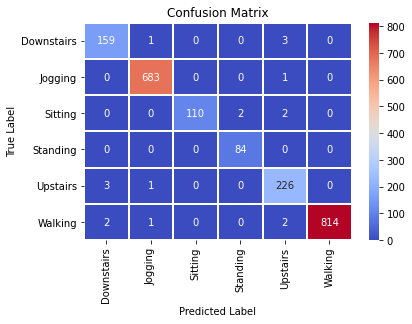

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       163
           1       1.00      1.00      1.00       684
           2       1.00      0.96      0.98       114
           3       0.98      1.00      0.99        84
           4       0.97      0.98      0.97       230
           5       1.00      0.99      1.00       819

    accuracy                           0.99      2094
   macro avg       0.98      0.99      0.99      2094
weighted avg       0.99      0.99      0.99      2094



In [60]:
history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))